# Distribued Hedging Simulation


In the previous notebook we have demonstrated how the discounted hedging cost is close to the option price at $T_0$

Now let's run large simulation in parallel using AWS Lambda and see for ourselves how this converges as the number of hedging steps increases.

## Imports

In [1]:
import boto3
import json
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt

from datetime import datetime
from ipywidgets import interact, widgets
from tqdm.notebook import tqdm, trange

## Initialisation

In [2]:
lambda_cli = boto3.client('lambda')
sqs = boto3.resource('sqs')
result_q = sqs.get_queue_by_name(QueueName='compute-result')
sns.set_theme()

## Lambda async call and poll SQS

In [3]:
def submit_job(tasks):
    requests = {}
    for task in tasks:
        res = lambda_cli.invoke_async(
            FunctionName='hedging_portfolio',
            InvokeArgs=json.dumps(task)
        )
        requests[res['ResponseMetadata']['RequestId']] = datetime.now()

    completed_tasks = 0
    while completed_tasks != len(tasks):
        messages = result_q.receive_messages()
        for message in messages:        
            body = json.loads(message.body)
            req_id = body['requestContext']['requestId']        
            request_time = requests.pop(req_id, None)
            if request_time:
                yield {
                    'request_time': request_time,
                    'requestPayload': body['requestPayload'],
                    'result': body['responsePayload']['body'],
                    'received_time': datetime.now()                    
                }
                completed_tasks += 1

            # Should only delete message related to the requests
            # But for this notebook assume there is only one user
            # and we want to keep the queue clean
            message.delete()

Interesting reading:

Provisioned concurrency: https://aws.amazon.com/blogs/aws/new-provisioned-concurrency-for-lambda-functions/

Cold start timing: https://mikhail.io/serverless/coldstarts/aws/

## Homogeneous Tasks

let's run the same 1,000 simulations with 1,000 steps with 15 nodes.

Feel free to play around with the above numbers. For example it's interesting to run 15 nodes,
then change to 100 nodes You'll see that 15 tasks are faster due to warm start.

In [4]:
def create_task(n_steps, n_sims):
    return {
        'bs_kwargs': {
            'S0': 100.,
            'K': 100.,
            'sigma': 0.1,
            'r': 0.,
            'T': 1.,
            'mu': 0.,
            'n_steps': n_steps        
        },
        'sim_kwargs': {
            'n_sims': n_sims
        }
    }

Let's first do a single query

In [5]:
res = next(submit_job([create_task(1000, 1000)]))
res['received_time'] - res['request_time']

datetime.timedelta(seconds=5, microseconds=699504)

And now do it in parallel with 15 nodes

In [33]:
tasks = [create_task(1000, 1000)] * 15

results = []
with tqdm(total=len(tasks)) as pbar:
    for res in submit_job(tasks):
        results.append(res)
        pbar.update(1)

  0%|          | 0/15 [00:00<?, ?it/s]

### Timings

In [7]:
def get_timing_df(results):
    data = []

    for res in results:
        req_time = res['request_time'].timestamp()
        rec_time = res['received_time'].timestamp()        
        res = res['result']
        timing = res['timing']
        calc_start = timing['start']
        calc_end = timing['end']
        data.append((req_time, calc_start, calc_end, rec_time))

    df = pd.DataFrame(data, columns=['req_time', 'calc_start', 'calc_end', 'rec_time'])
    df['calc_time'] = df.calc_end - df.calc_start
    df['tot_time'] = df.rec_time - df.req_time
    df['overhead'] = df.tot_time-df.calc_time
    return df.sort_values('tot_time')

In [8]:
def plot_timing(results):
    df = get_timing_df(results)
    plt.figure(figsize=(12,6))

    x=np.arange(len(results))
    y=[df.calc_time, df.overhead]
    
    avg_overhead = df.overhead.mean()
    avg_tot = df.tot_time.mean()
    percent_overhead = avg_overhead / avg_tot * 100.

    plt.title(f'Avg Total Time: {avg_tot:.2f}s, Avg Overhead: {avg_overhead:.2f}s, Percent Overhead: {percent_overhead:.0f}%')
    plt.stackplot(x,y, labels=['Calc Time', 'Overhead'])
    plt.legend(loc='upper left')
    plt.show()

So the overhead is only 0.28s. Which is 15% of the total time (Number may vary).

The total calculation time was very short (1.85s). If we get each task to do more work,
we'd decrease the overhead. But of course, we'd increase wall clock time.

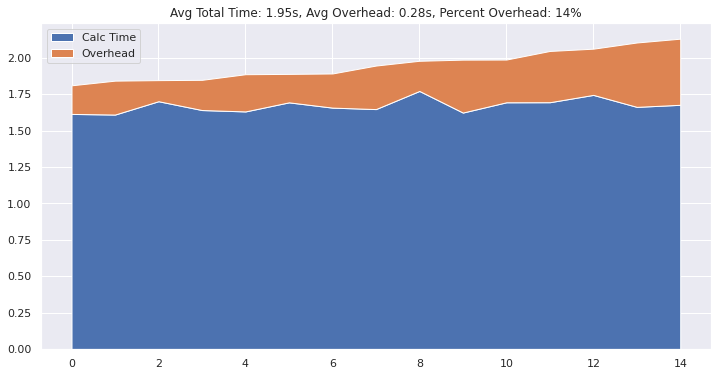

In [34]:
plot_timing(results)

Slide the slider to pick results from each task

In [13]:
@interact(i=widgets.IntSlider(max=len(results)-1))
def f(i):
    x = results[i]['result']['result']['costs']
    ax = sns.histplot(x=x, bins=30, kde=True)

interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',…

Combining the results gives us a smoother distribution.

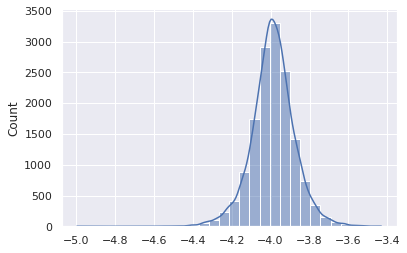

In [16]:
x = np.array(list(itertools.chain.from_iterable(r['result']['result']['costs'] for r in results)))
ax = sns.histplot(x=x, bins=30, kde=True)

## Heterogeneous Tasks

We'll try 

Let's first do it Naively and just run different `n_steps` per task

### Problem 1, the tasks are too small

In [17]:
tasks = [create_task(i, 1000) for i in [20, 50, 100, 260]]

results = []
with tqdm(total=len(tasks)) as pbar:
    for res in submit_job(tasks):
        results.append(res)
        pbar.update(1)

  0%|          | 0/4 [00:00<?, ?it/s]

As we can see the overhead is massive compare to the calc time. We could bunch those tasks together.

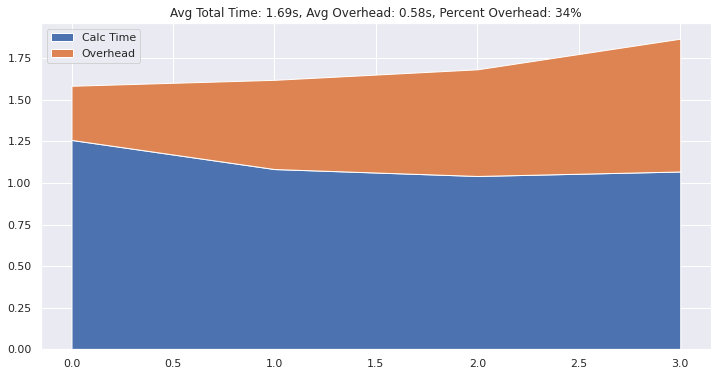

In [18]:
plot_timing(results)

In [19]:
def map_reduce(results):
    data = []
    for res in results:
        n_steps = res['requestPayload']['bs_kwargs']['n_steps']
        data += [(n_steps, x) for x in res['result']['result']['costs']]

    return pd.DataFrame(data, columns=['n_steps', 'cost'])

Now we have a data, let look at a pretty violine chart to convince ourselves that as the number
of hedging steps increases the closer we on to the option price on any given simulation.

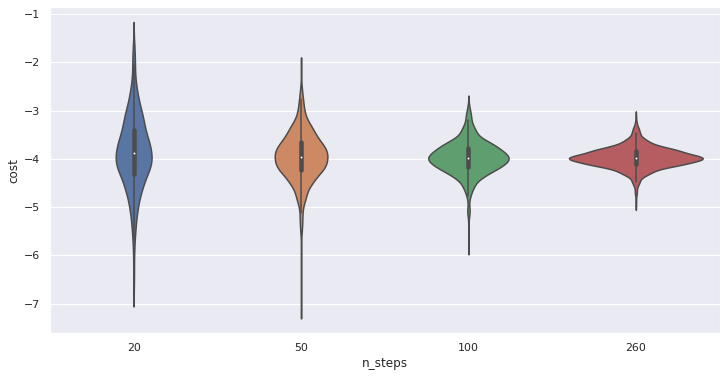

In [20]:
df = map_reduce(results)
plt.figure(figsize=(12,6))
ax = sns.violinplot(x="n_steps", y="cost", data=df)

### Problem 2, tasks too large

In [21]:
tasks = [create_task(10**i, 1000) for i in range(1, 6)]

results = []
with tqdm(total=len(tasks)) as pbar:
    for res in submit_job(tasks):
        results.append(res)
        pbar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

Oops. Not a clever distribution strategy at all. Took 70+ seconds to do 1M steps 1,000 times.

The distributed compute is only as fast as the slowest task.

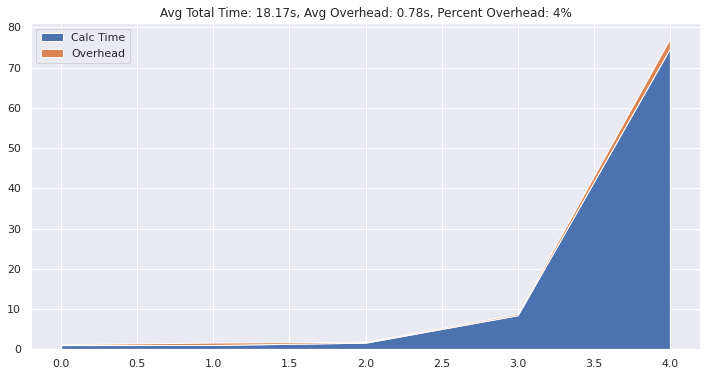

In [22]:
plot_timing(results)

### Better distribution strategy

Let's change the strategy by splitting the heavier tasks into samller chunks.

In [28]:
task_splits = [(10**i, 1000) for i in range(1, 4)] + [(int(1e5), 50)] * 20 + [(int(1e6), 10)] * 100
tasks = [create_task(*x) for x in task_splits]

results = []
with tqdm(total=len(tasks)) as pbar:
    for res in submit_job(tasks):
        results.append(res)
        pbar.update(1)

  0%|          | 0/123 [00:00<?, ?it/s]

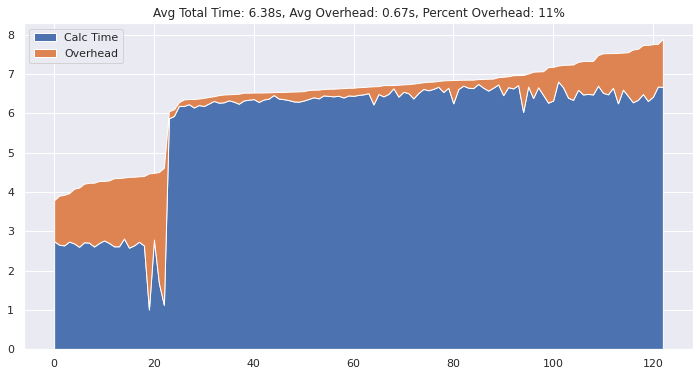

In [29]:
plot_timing(results)

In [30]:
data = []
for res in results:
    n_steps = res['requestPayload']['bs_kwargs']['n_steps']
    data += [(n_steps, x) for x in res['result']['result']['costs']]
    
df = pd.DataFrame(data, columns=['n_steps', 'cost'])

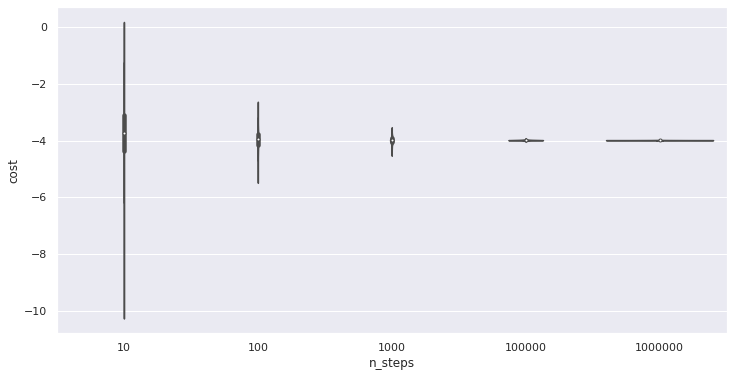

In [31]:
df = map_reduce(results)
plt.figure(figsize=(12,6))
ax = sns.violinplot(x="n_steps", y="cost", data=df)

In [32]:
@interact(i=widgets.IntSlider(min=1, max=6))
def f(i):    
    ax = sns.histplot(x=df[df.n_steps == 10**i].cost, bins=30, kde=True)

interactive(children=(IntSlider(value=1, description='i', max=6, min=1), Output()), _dom_classes=('widget-inte…